In [31]:
from pylab import *
%matplotlib inline
import caffe
caffe_root="/home/mady/caffe/"


In [2]:
# run scripts from caffe root
import os
os.chdir(caffe_root)
# Download data
!data/mnist/get_mnist.sh
# Prepare data
!examples/mnist/create_mnist.sh
# back to examples
os.chdir('examples')

Downloading...
Creating lmdb...
I0613 23:14:18.017468   855 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I0613 23:14:18.026036   855 convert_mnist_data.cpp:88] A total of 60000 items.
I0613 23:14:18.026057   855 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0613 23:14:24.704030   855 convert_mnist_data.cpp:108] Processed 60000 files.
I0613 23:14:24.840770   858 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I0613 23:14:24.841028   858 convert_mnist_data.cpp:88] A total of 10000 items.
I0613 23:14:24.841042   858 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0613 23:14:25.826879   858 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


In [3]:
from caffe import layers as L, params as P

In [4]:
def lenet(lmdb,batch_size):
    n=caffe.NetSpec()
    
    #data layer
    n.data,n.label= L.Data(batch_size=batch_size,backend=P.Data.LMDB,source=lmdb,
                           transform_param=dict(scale=1/.255),ntop=2)
    
    #conv layer
    n.conv1=L.Convolution(n.data,kernel_size=5,num_output=20,weight_filler=dict(type='xavier'))
    
    #pooling layer
    n.pool1=L.Pooling(n.conv1,kernel_size=2,stride=2,pool=P.Pooling.MAX)
    
    n.conv2=L.Convolution(n.pool1,kernel_size=5,num_output=50,weight_filler=dict(type='xavier'))
    n.pool2=L.Pooling(n.conv2,kernel_size=2,stride=2,pool=P.Pooling.MAX)
    
    #full connected inner product layer
    n.fc1=L.InnerProduct(n.pool2,num_output=500,weight_filler=dict(type='xavier'))
    
    #activation layer
    n.relu=L.ReLU(n.fc1,in_place=True)
    
    
    n.score=L.InnerProduct(n.relu,num_output=10,weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()


In [5]:
with open("/home/mady/caffevision/caffe/tutos/tuto2-leNet_MNIST/lenet_auto_train.prototxt","w") as f:
    f.write(str(lenet("mnist/mnist_train_lmdb",64)))

with open("/home/mady/caffevision/caffe/tutos/tuto2-leNet_MNIST/lenet_auto_test.prototxt","w") as f:
    f.write(str(lenet("mnist/mnist_test_lmdb",100)))

In [6]:
!cat /home/mady/caffevision/caffe/tutos/tuto2-leNet_MNIST/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 3.92156863213
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_output

In [7]:
#Loading and checking the solver
solver=None
solver = caffe.SGDSolver('/home/mady/caffevision/caffe/tutos/tuto2-leNet_MNIST/lenet_auto_solver.prototxt')

In [8]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [9]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

In [10]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(80.88660430908203, dtype=float32)}

(-0.5, 27.5, 27.5, -0.5)

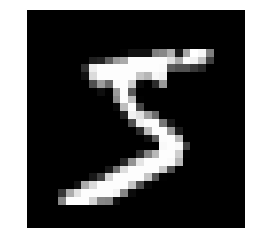

In [11]:
imshow(solver.net.blobs['data'].data[:1, 0].reshape(28,1*28),cmap='gray'); axis('off')

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


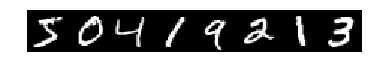

In [12]:
# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


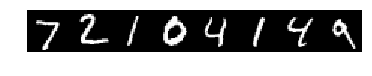

In [13]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

In [14]:
solver.step(1) #Let's take one step of (minibatch) SGD and see what happens.

(-0.5, 24.5, 19.5, -0.5)

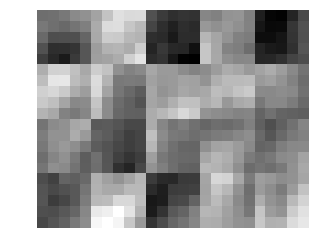

In [15]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); axis('off')

In [16]:
#training the model
%time
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs
Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...


In [17]:
output[0]

array([[  8.70410663e+15,  -2.08615237e+17,   3.70381143e+16,
          2.68935691e+16,   2.94019223e+16,   1.87180688e+16,
          2.91244438e+16,   1.84736680e+16,   1.13246713e+16,
          2.89400351e+16],
       [  2.45378783e+17,  -6.39834074e+18,   1.13508007e+18,
          7.79715029e+17,   8.79822470e+17,   5.69056091e+17,
          9.05355535e+17,   5.41095820e+17,   4.89098025e+17,
          8.53789127e+17],
       [  2.09021971e+16,  -5.40049738e+17,   9.72638895e+16,
          6.64218625e+16,   7.44683764e+16,   4.88589810e+16,
          7.73312813e+16,   4.60499135e+16,   3.82002165e+16,
          7.05686792e+16],
       [  4.35214705e+17,  -1.12949234e+19,   1.99387830e+18,
          1.37646321e+18,   1.55635472e+18,   9.99582582e+17,
          1.59143767e+18,   9.56933076e+17,   8.63401333e+17,
          1.52162747e+18],
       [  2.13727554e+17,  -5.56035620e+18,   9.80972386e+17,
          6.76571561e+17,   7.68676619e+17,   4.92030354e+17,
          7.85948023e+17

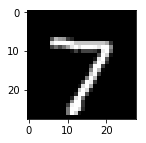

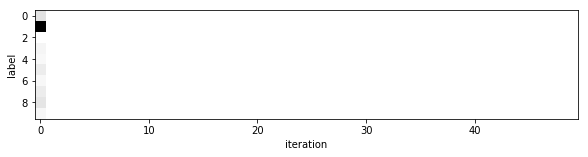

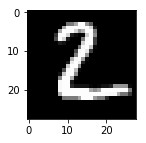

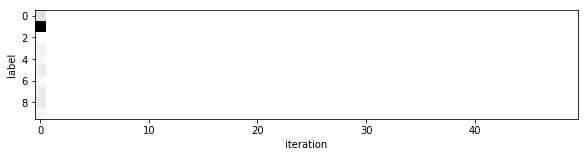

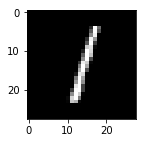

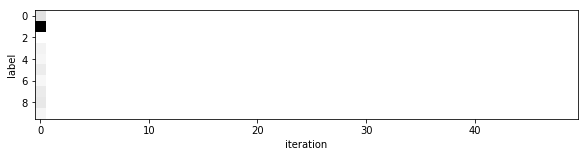

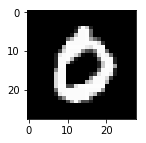

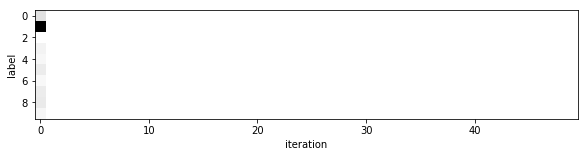

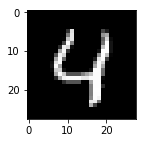

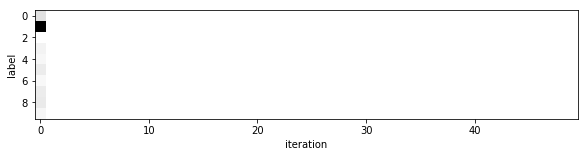

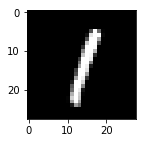

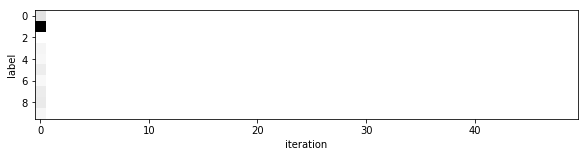

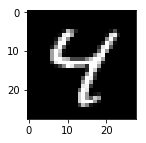

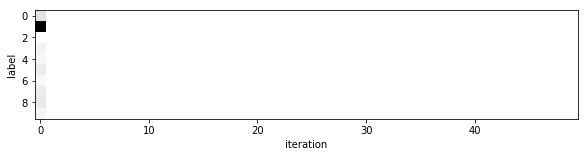

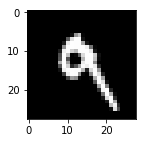

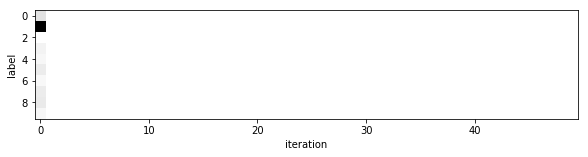

In [18]:
#plotting
for i in range(8):
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    figure(figsize=(10, 2))
    imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')

In [19]:
len(output)

200

In [24]:
output[1][0]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [33]:
, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))

TypeError: 'tuple' object is not callable